# **Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
# from keras.layers import Conv1D, BatchNormalization, Activation, MaxPooling1D, Flatten, Dense, Dropout
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Model
from keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Activation, Add, Flatten, BatchNormalization, ReLU, MaxPooling1D, Bidirectional, GRU, Dense
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.linear_model import HuberRegressor

# **Load data**

In [ ]:
# train_data [signal, label, index]
# hint: change the addresses if you wanna use other folds
train_data = np.load('/content/drive/MyDrive/Folds/fold_2/OCM_trainArray2.npy')
val_data = np.load('/content/drive/MyDrive/Folds/fold_2/OCM_valArray2.npy')
test_data = np.load('/content/drive/MyDrive/Folds/fold_2/OCM_testArray2.npy')
test_labels = np.load('/content/drive/MyDrive/Folds/fold_2/OCM_testAHI2.npy')

test_data = test_data[(test_data[:,-1] !=304.) & (test_data[:,-1] !=371.) & (test_data[:,-1] !=353.)]
test_labels = np.delete(test_labels, [108,113], axis=0)  # fold2: [108,113], fold1: [90]

# test_labels = np.delete(test_labels, [90], axis=0)      # if using fold1

val_data = np.random.permutation(val_data)
train_data = np.random.permutation(train_data)

X = train_data[:,:-2]
y = train_data[:,-2]

X_val = val_data[:,:-2]
y_val = val_data[:,-2]

X_test = test_data[:,:-2]
y_test = test_data[:,-2]

print("train data shape: ", X.shape, "train label shape: ",y.shape)
print("test data shape: ", X_test.shape, "test label shape: ", y_test.shape)


# balancing data by repeating non-zero labelled data

zero_X = X[y == 0]
zero_y = y[y == 0]
nonzero_X = X[y != 0]
nonzero_y = y[y != 0]
print("zero labelled data shape: ", zero_X.shape, "zero labelled label shape: ", zero_y.shape)
print("non-zero labelled data shape: ", nonzero_X.shape, "non-zero labelled label shape: ", nonzero_y.shape)

nonzero_data = np.hstack((nonzero_X, nonzero_y.reshape((-1, 1))))
zero_data = np.hstack((zero_X, zero_y.reshape((-1, 1))))
nonzero_data = np.repeat(nonzero_data, repeats=2, axis=0)
nonzero_data = np.random.permutation(nonzero_data)
zero_data = np.random.permutation(zero_data)

data = np.concatenate((zero_data, nonzero_data), axis=0)
new_train_data = np.random.permutation(data)

X_train = new_train_data[:,:-1]
y_train = new_train_data[:,-1]


print("balanced train data shape: ", X_train.shape, "balanced train label shape: ", y_train.shape)

train data shape:  (14672, 1200) train label shape:  (14672,)
test data shape:  (7349, 1200) test label shape:  (7349,)
zero labelled data shape:  (10000, 1200) zero labelled label shape:  (10000,)
non-zero labelled data shape:  (4672, 1200) non-zero labelled label shape:  (4672,)
balanced train data shape:  (19344, 1200) balanced train label shape:  (19344,)


# **Huber Regressor**

Mean Squared Error: 0.671558334324548


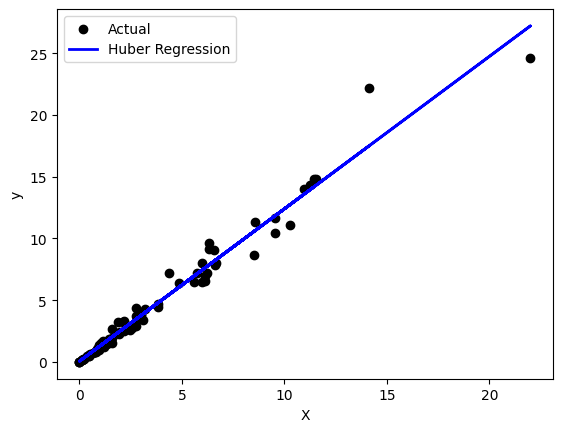

In [ ]:
# hint: change the addresses if you wanna use other folds
val_data = np.load('/content/drive/MyDrive/Folds/fold_2/OCM_valArray2.npy')
val_labels = np.load('/content/drive/MyDrive/Folds/fold_2/OCM_valAHI2.npy')

X = val_labels[:, 0]/((20./60.) * np.unique(val_data[:,-1], return_counts=True)[1])
y = val_labels[:, 0]/(val_labels[:, 1] * (1/60))
X = X.reshape(-1,1)


# Create a Huber Regressor
huber = HuberRegressor(epsilon=9)

# Train the model
huber.fit(X, y)

# Make predictions
y_pred = huber.predict(X)

# Evaluate the performance
mse = mean_squared_error(y, y_pred)
print(f'Mean Squared Error: {mse}')

# Plot the results
plt.scatter(X, y, color='black', label='Actual')
plt.plot(X, y_pred, color='blue', linewidth=2, label='Huber Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

# **Define Base Model - Load Weights**

## **Tensorflow**

### **CNN-BiGRU-Attention**

In [ ]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # e = K.tanh(K.dot(x, self.W) + self.b)
        e = K.relu(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a

        # Sum over the time steps
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])



# Define input layer
input_signal = Input(shape=(1200, 1))

# CNN layer
x = Conv1D(filters=64, kernel_size=3, padding='same')(input_signal)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling1D(pool_size=3)(x)

# Bi-GRU layer
bigru = Bidirectional(GRU(units=64, return_sequences=True))(x)

# Attention layer (custom implementation required)
attention_output = AttentionLayer()(bigru)
# multi_attention_layer(bigru)

# Output layer
output = Dense(units=1)(attention_output)  # Predicting a single value

# Build model
model = Model(inputs=input_signal, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=Huber(delta=1.5), metrics=[RootMeanSquaredError(),'mae'])

# def lr_scheduler(epoch, lr):
#     if epoch % 10 == 0 and epoch > 0:
#         lr = lr * 0.5
#     return lr

# # Create the learning rate scheduler callback
# lr_callback = LearningRateScheduler(lr_scheduler)

# # Define early stopping to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, mode='min')
# # Train the model with early stopping
# history = model.fit(X_train, y_train, epochs=300, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping,lr_callback])

model.load_weights("/content/attention_model_fold_2_weights.h5")
model.summary()

print("test-segments-metrics")
print("Loss      -      RMSE           -      MAE     ")
model.evaluate(X_test, y_test, verbose=0)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 1200, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_35 (Conv1D)                   │ (None, 1200, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 1200, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 1200, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 400, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 400, 128)            │          49,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_1 (AttentionLayer)   │ (None, 128)                 │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,089 (199.57 KB)

 Trainable params: 50,961 (199.07 KB)

 Non-trainable params: 128 (512.00 B)

test-segments-metrics
Loss      -      RMSE           -      MAE     


[0.39019572734832764, 1.2221266031265259, 0.5247697830200195]

#### **Metrics**

In [ ]:
y_pred = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))

# Assuming y_test and y_pred are your actual and predicted target values for the test set
r_squared = r2_score(y_test, y_pred)
print("R-squared value:", r_squared)

unique_indices = np.unique(test_data[:, -1])
y_pred = y_pred.ravel()
# Iterate over unique indices and calculate the sum of pred labels from same index
per_subject_sums = []
for index in unique_indices:
    subset = y_pred[test_data[:, -1] == index]
    per_segment_sum = np.sum(subset)
    per_subject_sums.append(per_segment_sum)

sleep_durations = test_labels[:, 1] * (1/60)
AHI = test_labels[:, 0] / sleep_durations
total_records_times = (20./60.) * np.unique(test_data[:,-1], return_counts=True)[1]
pred_AHI = np.array(per_subject_sums) / total_records_times

# Calculate RMSE
Y_pred = huber.predict(pred_AHI.reshape(-1,1))
# Print RMSE
rmse = np.sqrt(mean_squared_error(AHI, Y_pred))
print(f"RMSE: {rmse}")

predicted_classes = np.where(Y_pred < 1, 1, np.where(Y_pred < 5, 2, np.where(Y_pred < 10, 3, 4)))
LABELS = np.where(AHI < 1, 1, np.where(AHI < 5, 2, np.where(AHI < 10, 3, 4)))

# Calculate the accuracy
accuracy = accuracy_score(LABELS, predicted_classes)

# Print the accuracy
print("4-class Accuracy:", accuracy)

230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
R-squared value: 0.8167936092649283
RMSE: 1.6875472016606554
4-class Accuracy: 0.7768924302788844


### **ResNet**

In [ ]:
# def lr_scheduler(epoch, lr):
#     if epoch % 10 == 0 and epoch > 0:
#         lr = lr * 0.5
#     return lr

# # Create the learning rate scheduler callback
# lr_callback = LearningRateScheduler(lr_scheduler)

# from tensorflow.keras.callbacks import ReduceLROnPlateau
# lr_reduction = ReduceLROnPlateau(min_delta=0.01, monitor='val_loss', patience=5, factor=0.5, min_lr=0.00000001, verbose=1)

def residual_block(input_tensor, filters, kernel_size, strides):
    x = Conv1D(filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_regularizer=l2(0.01), kernel_initializer='he_normal')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if strides != 1:
        input_tensor = Conv1D(filters, kernel_size=1, strides=strides, padding='same')(input_tensor)
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

def build_resnet(input_shape):

    spo2_input = Input(shape=input_shape)

    x = Conv1D(64, kernel_size=7, strides=2, padding='same', kernel_regularizer=l2(0.01), kernel_initializer='he_normal')(spo2_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(x, filters=64, kernel_size=10, strides=1)
    x = residual_block(x, filters=64, kernel_size=10, strides=1)
    x = residual_block(x, filters=64, kernel_size=10, strides=1)

    x = residual_block(x, filters=128, kernel_size=10, strides=2)
    x = residual_block(x, filters=128, kernel_size=10, strides=1)


    x = residual_block(x, filters=256, kernel_size=10, strides=2)
    x = residual_block(x, filters=256, kernel_size=10, strides=1)


    x = Flatten()(x)
    x = Dense(1000, activation='relu', kernel_regularizer=l2(0.01), kernel_initializer='he_normal')(x)
    x = Dense(1, activation='linear')(x)

    model = Model(inputs=spo2_input, outputs=x)
    return model

# Define the input shape
input_shape = (1200, 1)

# Build the ResNet model
model = build_resnet(input_shape)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=Huber(delta=1.5), metrics=[RootMeanSquaredError(),'mae'])  #Huber(delta=1.5)

# # Define early stopping to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, mode='min')
# # Train the model with early stopping
# history = model.fit(X_train, y_train, epochs=300, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping,lr_callback])

model.load_weights("/content/resnet_model_fold_2_weights.h5")
model.summary()
print("test-segments-metrics")
print("Loss      -      RMSE           -      MAE     ")
model.evaluate(X_test, y_test, verbose=0)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 1200, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_18 (Conv1D)        │ (None, 600, 64)        │            512 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 600, 64)        │            256 │ conv1d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_15             │ (None, 600, 64)        │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 300, 64)        │              0 │ activation_15[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_19 (Conv1D)        │ (None, 300, 64)        │         41,024 │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 300, 64)        │            256 │ conv1d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_16             │ (None, 300, 64)        │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_20 (Conv1D)        │ (None, 300, 64)        │         41,024 │ activation_16[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 300, 64)        │            256 │ conv1d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 300, 64)        │              0 │ batch_normalization_1… │
│                           │                        │                │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_17             │ (None, 300, 64)        │              0 │ add_7[0][0]            │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_21 (Conv1D)        │ (None, 300, 64)        │         41,024 │ activation_17[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 300, 64)        │            256 │ conv1d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18        

 Total params: 22,366,673 (85.32 MB)

 Trainable params: 22,362,705 (85.31 MB)

 Non-trainable params: 3,968 (15.50 KB)

test-segments-metrics
Loss      -      RMSE           -      MAE     


[0.5794086456298828, 1.3304579257965088, 0.612430214881897]

#### **Metrics**

In [ ]:
y_pred = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))

# Assuming y_test and y_pred are your actual and predicted target values for the test set
r_squared = r2_score(y_test, y_pred)
print("R-squared value:", r_squared)

unique_indices = np.unique(test_data[:, -1])
y_pred = y_pred.ravel()
# Iterate over unique indices and calculate the sum of pred labels from same index
per_subject_sums = []
for index in unique_indices:
    subset = y_pred[test_data[:, -1] == index]
    per_segment_sum = np.sum(subset)
    per_subject_sums.append(per_segment_sum)

sleep_durations = test_labels[:, 1] * (1/60)
AHI = test_labels[:, 0] / sleep_durations
total_records_times = (20./60.) * np.unique(test_data[:,-1], return_counts=True)[1]
pred_AHI = np.array(per_subject_sums) / total_records_times

# Calculate RMSE
Y_pred = huber.predict(pred_AHI.reshape(-1,1))
# Print RMSE
rmse = np.sqrt(mean_squared_error(AHI, Y_pred))
print(f"RMSE: {rmse}")

predicted_classes = np.where(Y_pred < 1, 1, np.where(Y_pred < 5, 2, np.where(Y_pred < 10, 3, 4)))
LABELS = np.where(AHI < 1, 1, np.where(AHI < 5, 2, np.where(AHI < 10, 3, 4)))

# Calculate the accuracy
accuracy = accuracy_score(LABELS, predicted_classes)

# Print the accuracy
print("4-class Accuracy:", accuracy)

230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
R-squared value: 0.7828746592137246
RMSE: 1.7155333808711228
4-class Accuracy: 0.7290836653386454


## **Pytorch**

### **Initiate Tensors**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = torch.from_numpy(X_train).float().unsqueeze(1).to(device)
y_train = torch.from_numpy(y_train).float().unsqueeze(1).to(device)
X_val = torch.from_numpy(X_val).float().unsqueeze(1).to(device)
y_val = torch.from_numpy(y_val).float().unsqueeze(1).to(device)
X_test = torch.from_numpy(X_test).float().unsqueeze(1).to(device)
y_test = torch.from_numpy(y_test).float().unsqueeze(1).to(device)

### **Dataset and DataLoader**

In [ ]:
# Dataset and DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

### **CNN-BiGRU-Attention**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split



class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.W = nn.Parameter(torch.randn(input_dim, 1))
        self.b = nn.Parameter(torch.zeros(1, 400, 1))
        self.alpha_vectors = []

    def forward(self, x):
        e = torch.relu(torch.matmul(x, self.W) + self.b)
        alpha_vector = torch.softmax(e, dim=1)
        # print("alpha: ",a.size())
        self.alpha_vectors.append(alpha_vector)
        output = x * alpha_vector
        return torch.sum(output, dim=1), alpha_vector

class CNNBiGRUAttentionModel(nn.Module):
    def __init__(self):
        super(CNNBiGRUAttentionModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding='same')
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool1d(kernel_size=3)
        self.bigru = nn.GRU(input_size=64, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)
        self.attention = AttentionLayer(input_dim=128)  # 128 because of bidirectional GRU (64*2)
        self.fc = nn.Linear(in_features=128, out_features=1)

    def forward(self, x):
        # print(x.size())
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.max_pool(x)
        # print(x.size())
        x = x.permute(0, 2, 1)
        x, _ = self.bigru(x)
        # print(x.size())
        x, alpha_vector = self.attention(x)
        x = self.fc(x)
        return x, alpha_vector

# Learning rate scheduler
def lr_scheduler(optimizer, epoch):
    if epoch % 10 == 0 and epoch > 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.5



# Model, optimizer, loss function
model = CNNBiGRUAttentionModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.HuberLoss(delta=1.5)

epoch:  0
Epoch 1/300, Loss: 2.090539313975734, Val Loss: 1.4390727752133419
epoch:  1
Epoch 2/300, Loss: 1.9111769559359786, Val Loss: 6.300161662854646
epoch:  2
Epoch 3/300, Loss: 1.379194553634121, Val Loss: 10.230070917229904
epoch:  3
Epoch 4/300, Loss: 1.1518147854325007, Val Loss: 5.577223238192107
epoch:  4
Epoch 5/300, Loss: 1.0542388371508506, Val Loss: 0.8503640529356504
epoch:  5
Epoch 6/300, Loss: 0.9935569280248271, Val Loss: 0.9352506187401319
epoch:  6
Epoch 7/300, Loss: 0.9247890294778465, Val Loss: 1.4954389098443484
epoch:  7
Epoch 8/300, Loss: 0.8883932457111849, Val Loss: 3.8264739513397217
epoch:  8
Epoch 9/300, Loss: 0.8627260367665747, Val Loss: 0.5591743423750526
epoch:  9
Epoch 10/300, Loss: 0.8434885069482004, Val Loss: 0.6692459167618501
epoch:  10
Epoch 11/300, Loss: 0.8310115413844782, Val Loss: 1.3784316911509162
epoch:  11
Epoch 12/300, Loss: 0.7795107359736666, Val Loss: 0.6959129752297151
epoch:  12
Epoch 13/300, Loss: 0.7891678338987206, Val Loss: 0.

<ipython-input-49-6f918bdda4f0>:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Loss: 0.39865885233992465


#### **Training the model**

In [ ]:
# Training the model
num_epochs = 300
best_val_loss = float('inf')
patience = 30
counter = 0

for epoch in range(num_epochs):
    print("epoch: ",epoch)
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs, a = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    lr_scheduler(optimizer, epoch)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs, a = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

#### **Load Weights**

In [ ]:
# Load the best model and evaluate on the test set
model.load_state_dict(torch.load('attention_model_pytorch_fold_2.pth'))
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs, a = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

print(f"Test Loss: {test_loss/len(test_loader)}")

<ipython-input-54-54cb49b3ab98>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Loss: 0.41283661227511326


#### **Attention weights**

In [ ]:
results_list = []
alpha_vec_list = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs, alpha_vec = model(inputs)
        results_list.append(outputs.cpu().numpy())
        alpha_vec_list.append(alpha_vec.cpu().numpy())

In [ ]:
alpha_arr = np.vstack(alpha_vec_list)
predicts = np.vstack(results_list)

In [ ]:
alpha_arr.shape

(7349, 400, 1)

In [ ]:
np.unique(y_test.cpu().numpy(), return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 29., 30., 31., 32., 33., 34., 35., 37.], dtype=float32),
 array([5229,  975,  398,  201,  126,   87,   62,   34,   35,   35,   22,
          20,   16,   20,   13,   11,   11,    5,   10,    5,    2,    4,
           1,    3,    3,    4,    4,    1,    2,    2,    2,    1,    1,
           1,    2,    1]))

In [ ]:
torch.where(y_test == 37)[0]

tensor([6984], device='cuda:0')

In [ ]:
torch.where(y_test == 35)[0]

tensor([2898, 5396], device='cuda:0')

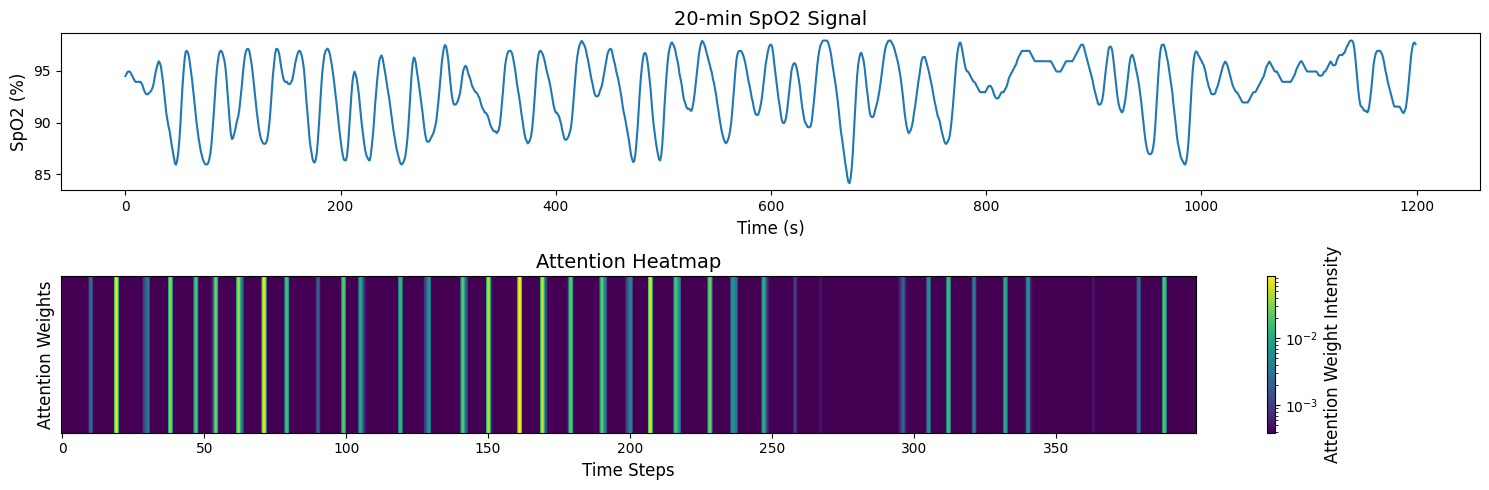

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Create a figure with two subplots (one for SpO2 signal, one for attention heatmap)
fig, axis = plt.subplots(2, 1, figsize=(15, 5))

# Time axis for the SpO2 signal
t = np.arange(0, 1200)

# Plot the SpO2 signal (assuming X_test is a PyTorch tensor)
axis[0].plot(t, X_test[5396].cpu().squeeze(0))
axis[0].set_title("20-min SpO2 Signal", fontsize=14)
axis[0].set_xlabel("Time (s)", fontsize=12)
axis[0].set_ylabel("SpO2 (%)", fontsize=12)
# axis[0].grid(True)

# Plot the attention heatmap (assuming alpha_arr is already loaded and in proper shape)
heatmap_data = alpha_arr[5396].reshape(-1, 400)

im = axis[1].imshow(heatmap_data, cmap='viridis', aspect='auto', norm=LogNorm())
axis[1].set_title("Attention Heatmap", fontsize=14)
axis[1].set_xlabel("Time Steps", fontsize=12)
axis[1].set_ylabel("Attention Weights", fontsize=12)
axis[1].set_yticks([])  # Remove y-ticks for clarity

# Add color bar to the heatmap
cbar = fig.colorbar(im, ax=axis[1])
cbar.set_label('Attention Weight Intensity', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


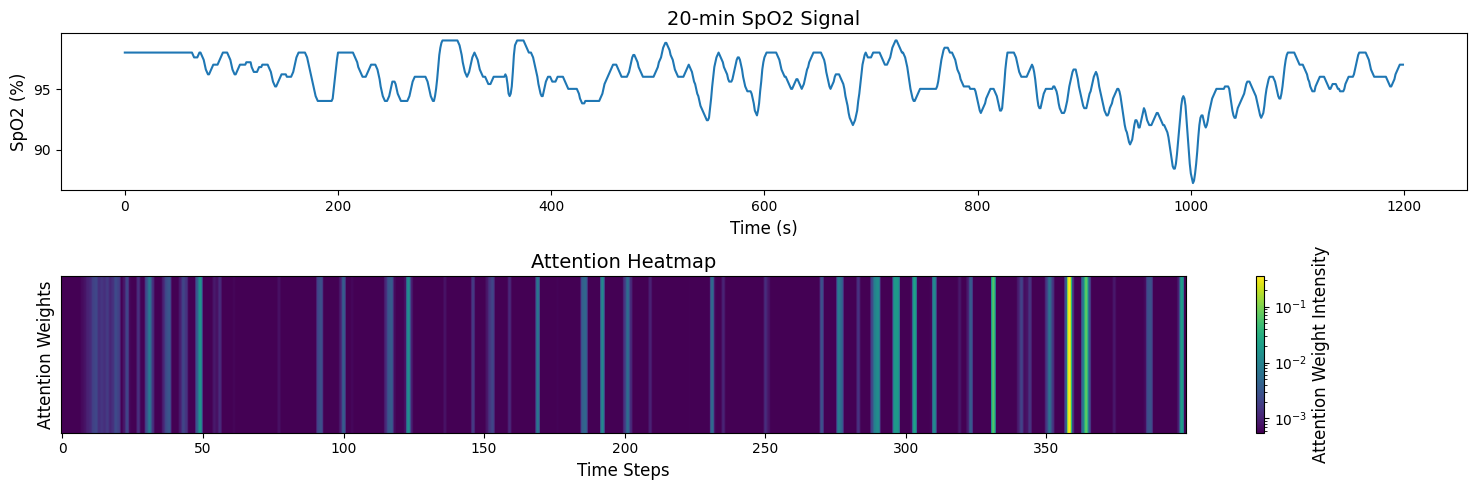

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Create a figure with two subplots (one for SpO2 signal, one for attention heatmap)
fig, axis = plt.subplots(2, 1, figsize=(15, 5))

# Time axis for the SpO2 signal
t = np.arange(0, 1200)

# Plot the SpO2 signal (assuming X_test is a PyTorch tensor)
axis[0].plot(t, X_test[867].cpu().squeeze(0))
axis[0].set_title("20-min SpO2 Signal", fontsize=14)
axis[0].set_xlabel("Time (s)", fontsize=12)
axis[0].set_ylabel("SpO2 (%)", fontsize=12)
# axis[0].grid(True)

# Plot the attention heatmap (assuming alpha_arr is already loaded and in proper shape)
heatmap_data = alpha_arr[867].reshape(-1, 400)

im = axis[1].imshow(heatmap_data, cmap='viridis', aspect='auto', norm=LogNorm())
axis[1].set_title("Attention Heatmap", fontsize=14)
axis[1].set_xlabel("Time Steps", fontsize=12)
axis[1].set_ylabel("Attention Weights", fontsize=12)
axis[1].set_yticks([])  # Remove y-ticks for clarity

# Add color bar to the heatmap
cbar = fig.colorbar(im, ax=axis[1])
cbar.set_label('Attention Weight Intensity', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


#### **Metrics**

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
test_data = np.load('/content/drive/MyDrive/Folds/fold_2/OCM_testArray2.npy')
test_labels = np.load('/content/drive/MyDrive/Folds/fold_2/OCM_testAHI2.npy')
test_data = test_data[(test_data[:,-1] !=304.) & (test_data[:,-1] !=371.) & (test_data[:,-1] !=353.)]
X_test = test_data[:,:-2]
y_test = test_data[:,-2]
test_labels = np.delete(test_labels, [108,113], axis=0)  #[108,113] [90]
# y_pred = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
# Assuming y_test and y_pred are your actual and predicted target values for the test set
r_squared = r2_score(y_test, predicts)
print("R-squared value:", r_squared)

unique_values = np.unique(test_data[:, -1])
y_pred = predicts.ravel()
# Iterate over unique values and calculate the sum of column 1
sums = []
for value in unique_values:
    subset = y_pred[test_data[:, -1] == value]
    column1_sum = np.sum(subset)
    sums.append(column1_sum)

sleep_dur = test_labels[:, 1] * (1/60)
AHI = test_labels[:, 0] / sleep_dur
pred_AHI = np.array(sums) / ((20./60.) * np.unique(test_data[:,-1], return_counts=True)[1])

# Calculate RMSE
Y_pred = huber.predict(pred_AHI.reshape(-1,1))
# Print RMSE
rmse = np.sqrt(mean_squared_error(AHI, Y_pred))
print(f"RMSE: {rmse}")

predicted_classes = np.where(Y_pred < 1, 1, np.where(Y_pred < 5, 2, np.where(Y_pred < 10, 3, 4)))
LABELS = np.where(AHI < 1, 1, np.where(AHI < 5, 2, np.where(AHI < 10, 3, 4)))
from sklearn.metrics import accuracy_score

# Calculate the accuracy
accuracy = accuracy_score(LABELS, predicted_classes)

# Print the accuracy
print("4-class Accuracy:", accuracy)

R-squared value: 0.8067992517860801
RMSE: 1.717052782059418
4-class Accuracy: 0.7330677290836654
